# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [45]:
import FINE as fn
from getData import getData
import os
import geopandas as gpd
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    1572.003960
cluster_1    2350.292663
cluster_2    2374.507270
cluster_3    2186.572278
cluster_4    1572.650655
cluster_5    1767.840650
cluster_6    2719.564564
cluster_7    1553.045964
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0       0.000000
cluster_1    4435.420314
cluster_2    4301.655834
cluster_3    3902.391858
cluster_4       0.000000
cluster_5       0.000000
cluster_6    4609.508396
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    1113.216464
cluster_1    1053.579422
cluster_2    1058.005181
cluster_3    1079.872237
cluster_4    1140.407380
cluster_5    1051.848141
cluster_6    1069.843344
cluster_7    1085.697466
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [14]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [15]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [17]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [18]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [19]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [20]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [22]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [23]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [24]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [25]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [27]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [28]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [29]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [30]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

#### All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, there are two ways to accomplish that:
(i) Spatial aggregation: Reducing the spatial resolution of the entire esM. 

(ii) Temporal aggregation: The time series data of the specified components can be clustered before the optimization. (The parameter timeSeriesAggregation is set to True in the optimize call if temporal aggregation is performed.)

# 8.1 Spatial Aggregation

In [31]:
shapefile = 'InputData/SpatialData/ShapeFiles/clusteredRegions.shp'

In [50]:
aggregated_esM = esM.aggregateSpatially(shapefilePath=shapefile, 
                                        grouping_mode='all_variable_based', 
                                        nRegionsForRepresentation=3,
                                        aggregatedResultsPath='OutputData')

Performing all variable-based clustering on the regions. Clustering mode: sklearn_hierarchical


 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:271: UserWarning:Variable gpd_geometries has dimensions ('space',) which are not considered for spatial aggregation.
 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:271: UserWarning:Variable gpd_centroids has dimensions ('space',) which are not considered for spatial aggregation.


The cophenetic correlation coefficient of the hiearchical clustering is  0.4269224974383427
Inconsistencies: [0.0, 0.7071067811865421, 0.0, 0.7071067811865466, 0.6130811433999683, 0.7071067811865495, 0.7071067811865476]
Silhouette scores:  [0.19259256890256637, 0.06717378691006956, 0.1370136253951097, 0.18188039476606646, 0.0008344424503486103, 0.07115203197830983]
elapsed time for all_variable_based_clustering: 0.01 minutes
Aggregation mode for 2d_locationalEligibility set to bool as only binary values are acceptable for this variable
Aggregation mode for 1d_locationalEligibility set to bool as only binary values are acceptable for this variable


 c:\users\s.patil\documents\code\fine\FINE\spagat\representation.py:120: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 c:\users\s.patil\documents\code\fine\FINE\utils.py:989: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:989: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:989: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\us

elapsed time for save_sds: 0.01 minutes


In [64]:
new_locations = list(aggregated_esM.locations)
new_locations

['cluster_5',
 'cluster_7',
 'cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6']

In [52]:
aggregated_esM.componentModelingDict['TransmissionModel'].componentsDict

{'AC cables': <FINE.transmission.Transmission at 0x1f8d4ee0d08>,
 'DC cables': <FINE.transmission.Transmission at 0x1f8d5cb1f88>,
 'Pipelines (biogas)': <FINE.transmission.Transmission at 0x1f8d6989788>,
 'Pipelines (hydrogen)': <FINE.transmission.Transmission at 0x1f8d5449608>}

# 8.2 Temporal Aggregation

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [53]:
aggregated_esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(0.4668 sec)



# 9 Optimization

In [54]:
aggregated_esM.optimize(timeSeriesAggregation=True, solver='gurobi')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2637 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1372 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.0965 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0950 sec)

Declaring shared potential constraint...
		(0.0010 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.3357 sec)

Declaring objective function...
		(0.1477 sec)

Using license file C:\Users\s.patil\gurobi.lic
Academic license - for non-com

 c:\users\s.patil\documents\code\fine\FINE\storage.py:1087: UserWarning:Charge and discharge at the same time for component Salt caverns (hydrogen)
 c:\users\s.patil\documents\code\fine\FINE\storage.py:1087: UserWarning:Charge and discharge at the same time for component Salt caverns (biogas)


for StorageModel ...       (2.1351sec)
for TransmissionModel ...  (1.2135sec)
		(4.9335 sec)



# 10. Selected Results Output

## 10.1. Plots for Spatial Aggregation Results 

#### Original spatial resolution

 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\

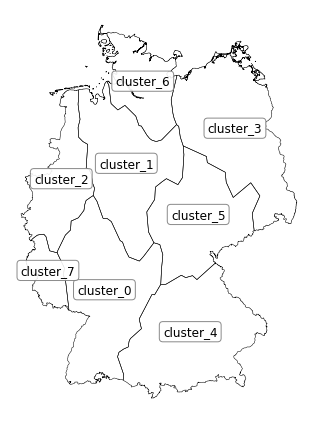

In [55]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

#### Spatial resolution after aggregation

 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


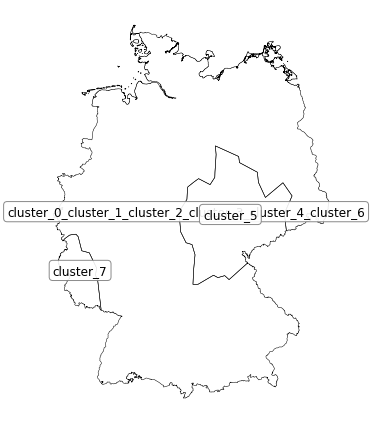

In [56]:
aggregated_regions_FilePath = os.path.join(cwd, 'OutputData', 'sds_regions.shp')
fig, ax = fn.plotLocations(aggregated_regions_FilePath, plotLocNames=True, indexColumn='space')

## 10.2. Sources and Sink Optimization Summary

In [57]:
aggregated_esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6  \
Component                    Property    Unit                                                                                  
Biogas purchase              TAC         [1e9 Euro/a]                                                             0            
                             commodCosts [1e9 Euro/a]                                                             0            
                             operation   [GW$_{biogas,LHV}$*h/a]                                                  0            
                                         [GW$_{biogas,LHV}$*h]                                                    0            
Electricity demand           operation   [GW$_{el}$*h/a]                                                     470635            
                                         [GW$_{el}$*h]                                                       470635            
Existing run-of-river plants TAC         [1e9 Euro/a]                                                       4.35129            
                             capacity    [GW$_{el}$]                                                        3.48661            
                             operation   [GW$_{el}$*h/a]                                                      79582            
                                         [GW$_{el}$*h]                                                        79582            
                             opexCap     [1e9 Euro/a]                                                       4.35129            
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]                                             62367.3            
                                         [GW$_{H_{2},LHV}$*h]                                               62367.3            
PV                           TAC         [1e9 Euro/a]                                                       70.7431            
                             capacity    [GW$_{el}$]                                                        36.2785            
                             capexCap    [1e9 Euro/a]                                                       67.9134            
                             invest      [1e9 Euro]                                                         141.486            
                             operation   [GW$_{el}$*h/a]                                                     220742            
                                         [GW$_{el}$*h]                                                       220742            
                             opexCap     [1e9 Euro/a]                                                       2.82973            
Wind (offshore)              TAC         [1e9 Euro/a]                                                       94.3138            
                             capacity    [GW$_{el}$]                                                        13.6687            
                             capexCap    [1e9 Euro/a]                                                       90.5412            
                             invest      [1e9 Euro]                                                         188.628            
                             operation   [GW$_{el}$*h/a]                                                     223590            
                                         [GW$_{el}$*h]                                                       223590            
                             opexCap     [1e9 Euro/a]                                                       3.77255            
Wind (onshore)               TAC         [1e9 Euro/a]                                                       3.09213            
                             capacity    [GW$_{el}$]                                                        0.93701            
                             capexCap    [1e9 Euro/a]                                            

#### Plot installed capacities

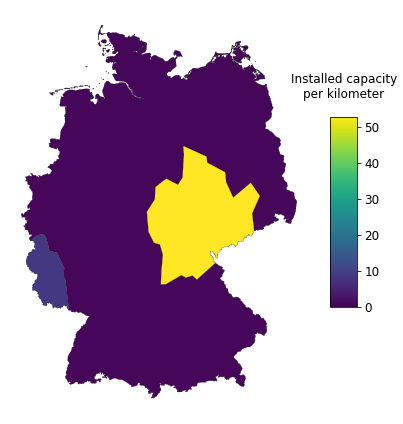

In [58]:
## 'Wind (onshore)'
fig, ax = fn.plotLocationalColorMap(aggregated_esM, 
                                    'Wind (onshore)', 
                                    aggregated_regions_FilePath, 
                                    'space',
                                    perArea=False)

In [59]:
gpd.read_file(locFilePath)

,index,geometry
0,cluster_0,"MULTIPOLYGON (((4223496.092 2734368.143, 42236..."
1,cluster_1,"MULTIPOLYGON (((4199685.633 3404002.686, 41996..."
2,cluster_2,"MULTIPOLYGON (((4106781.295 3394915.767, 41067..."
3,cluster_3,"MULTIPOLYGON (((4602449.935 3408647.034, 46024..."
4,cluster_4,"POLYGON ((4553700.750 2730225.831, 4553786.048..."
5,cluster_5,"POLYGON ((4571189.891 3067926.848, 4571184.381..."
6,cluster_6,"MULTIPOLYGON (((4235203.262 3440768.058, 42352..."
7,cluster_7,"MULTIPOLYGON (((4039023.418 2970178.496, 40390..."


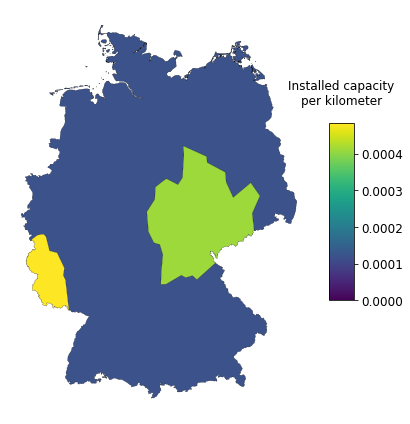

In [60]:
## 'PV'
fig, ax = fn.plotLocationalColorMap(aggregated_esM, 
                                    'PV', 
                                    aggregated_regions_FilePath, 
                                    'space', 
                                    perArea=True)

#### Plot operation time series (either one or two dimensional)

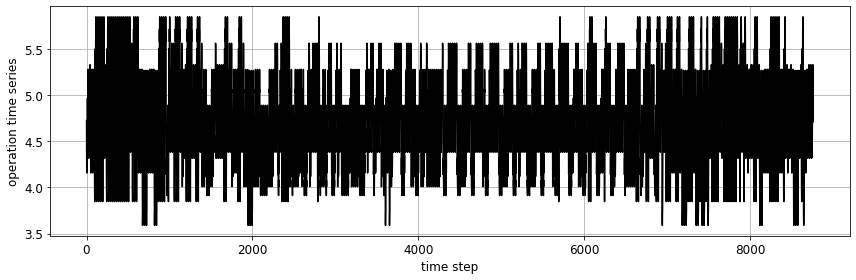

In [65]:
fig, ax = fn.plotOperation(aggregated_esM, 
                           'Electricity demand', 
                           new_locations[0])

## 10.2. Conversion Optimization Summary

In [66]:
aggregated_esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6  \
Component                  Property  Unit                                                                          
Electroylzers              TAC       [1e9 Euro/a]                                                 18.73            
                           capacity  [GW$_{el}$]                                                 12.363            
                           capexCap  [1e9 Euro/a]                                               17.8028            
                           invest    [1e9 Euro]                                                 37.0891            
                           operation [GW$_{el}$*h/a]                                            89096.2            
                                     [GW$_{el}$*h]                                              89096.2            
                           opexCap   [1e9 Euro/a]                                              0.927228            
New CCGT plants (biogas)   TAC       [1e9 Euro/a]                                                     0            
                           capacity  [GW$_{el}$]                                                      0            
                           capexCap  [1e9 Euro/a]                                                     0            
                           invest    [1e9 Euro]                                                       0            
                           operation [GW$_{el}$*h/a]                                                  0            
                                     [GW$_{el}$*h]                                                    0            
                           opexCap   [1e9 Euro/a]                                                     0            
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]                                                     0            
                           capacity  [GW$_{el}$]                                                      0            
                           capexCap  [1e9 Euro/a]                                                     0            
                           invest    [1e9 Euro]                                                       0            
                           operation [GW$_{el}$*h/a]                                                  0            
                                     [GW$_{el}$*h]                                                    0            
                           opexCap   [1e9 Euro/a]                                                     0            

                                                      cluster_5   cluster_7  
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]        2.2781   0.0206202  
                           capacity  [GW$_{el}$]        26.1806    0.236974  
                           capexCap  [1e9 Euro/a]       1.95084   0.0176581  
                           invest    [1e9 Euro]         13.0903    0.118487  
                           operation [GW$_{el}$*h/a]    60107.9     2075.89  
                                     [GW$_{el}$*h]      60107.9     2075.89  
                           opexCap   [1e9 Euro/a]      0.327257  0.00296217  
New CCGT plants (biogas)   TAC       [1e9 Euro/a]      0.120009  0.00723318  
                           capacity  [GW$_{el}$]        1.46717   0.0884294  
                           capexCap  [1e9 Euro/a]     0.0891984  0.00537617  
                           invest    [1e9 Euro]         1.02702   0.0619006  
                           operation [GW$_{el}$*h/a]    1826.63     677.723  
                                     [GW$_{el}$*h]      1826.63     677.723  
                           opexCap   [1e9 Euro/a]     0.0308106  0.00185702  
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]      0.893929           0  
                           capacity  [GW$_{el}$]        10

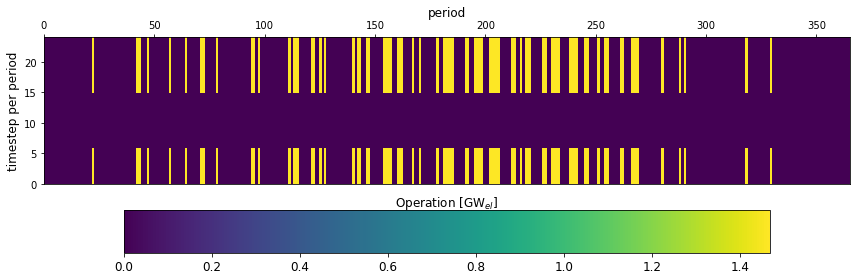

In [67]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'New CCGT plants (biogas)', 
                                   new_locations[0])

## 10.3. Storage Optimization Summary

In [68]:
aggregated_esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6  \
Component               Property           Unit                                                                                  
Li-ion batteries        TAC                [1e9 Euro/a]                                                             0            
                        capacity           [GW$_{el}$*h]                                                            0            
                        capexCap           [1e9 Euro/a]                                                             0            
                        invest             [1e9 Euro]                                                               0            
                        operationCharge    [GW$_{el}$*h/a]                                                          0            
                                           [GW$_{el}$*h]                                                            0            
                        operationDischarge [GW$_{el}$*h/a]                                                          0            
                                           [GW$_{el}$*h]                                                            0            
                        opexCap            [1e9 Euro/a]                                                             0            
Pumped hydro storage    TAC                [1e9 Euro/a]                                                      0.047647            
                        capacity           [GW$_{el}$*h]                                                       51.903            
                        operationCharge    [GW$_{el}$*h/a]                                                    12080.5            
                                           [GW$_{el}$*h]                                                      12080.5            
                        operationDischarge [GW$_{el}$*h/a]                                                    9354.22            
                                           [GW$_{el}$*h]                                                      9354.22            
                        opexCap            [1e9 Euro/a]                                                      0.047647            
Salt caverns (biogas)   TAC                [1e9 Euro/a]                                                             0            
                        capacity           [GW$_{biogas,LHV}$*h]                                                    0            
                        capexCap           [1e9 Euro/a]                                                             0            
                        invest             [1e9 Euro]                                                               0            
                        operationCharge    [GW$_{biogas,LHV}$*h/a]                                                  0            
                                           [GW$_{biogas,LHV}$*h]                                                    0            
                        operationDischarge [GW$_{biogas,LHV}$*h/a]                                                  0            
                                           [GW$_{biogas,LHV}$*h]                                                    0            
                        opexCap            [1e9 Euro/a]                                                             0            
Salt caverns (hydrogen) TAC                [1e9 Euro/a]                                                       6.03212            
                        capacity           [GW$_{H_{2},LHV}$*h]                                               1614.25            
                        capexCap           [1e9 Euro/a]                                                      0.511393            
                        invest             [1e9 Euro]                                                          1.0654            
                        operationChar

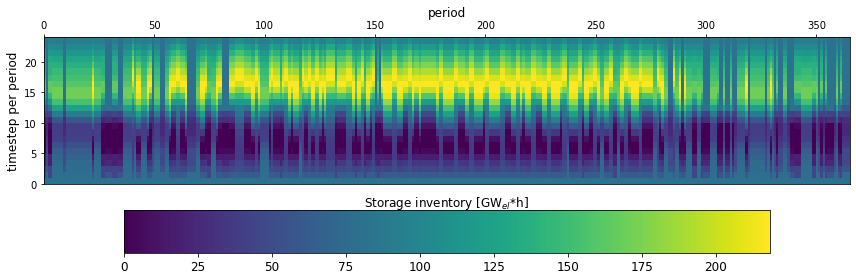

In [69]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Li-ion batteries', 
                                   new_locations[0], 
                                   variableName='stateOfChargeOperationVariablesOptimum')

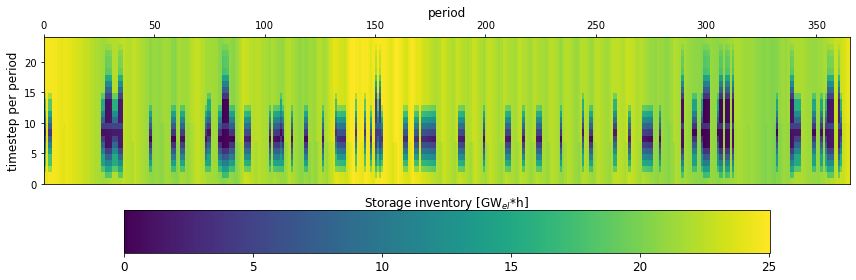

In [70]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Pumped hydro storage', 
                                   new_locations[0],
                                  variableName='stateOfChargeOperationVariablesOptimum')

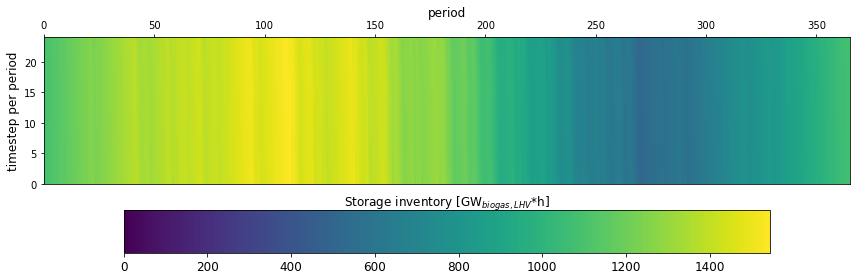

In [71]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Salt caverns (biogas)', 
                                   new_locations[0],
                                  variableName='stateOfChargeOperationVariablesOptimum')

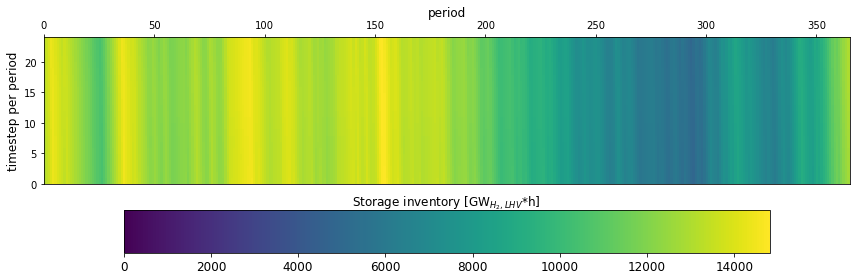

In [72]:
fig, ax = fn.plotOperationColorMap(aggregated_esM, 
                                   'Salt caverns (hydrogen)', 
                                   new_locations[0],
                                  variableName='stateOfChargeOperationVariablesOptimum')

## 10.4. Transmission Optimization Summary

In [73]:
#TODO: check why 'Pipelines' are not present here (they are present after spatial aggregation)
aggregated_esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6  \
Component Property  Unit            LocationIn                                                                                                       
AC cables capacity  [GW$_{el}$]     cluster_0_cluster_1_cluster_2_cluster_3_cluster...                                                NaN            
                                    cluster_5                                                                                          23            
                                    cluster_7                                                                                         5.5            
          operation [GW$_{el}$*h/a] cluster_0_cluster_1_cluster_2_cluster_3_cluster...                                                NaN            
                                    cluster_5                                                                                     91092.3            
                                    cluster_7                                                                                     16026.9            
                    [GW$_{el}$*h]   cluster_0_cluster_1_cluster_2_cluster_3_cluster...                                                NaN            
                                    cluster_5                                                                                     91092.3            
                                    cluster_7                                                                                     16026.9            
DC cables capacity  [GW$_{el}$]     cluster_0_cluster_1_cluster_2_cluster_3_cluster...                                                NaN            
                                    cluster_5                                                                                           4            
          operation [GW$_{el}$*h/a] cluster_0_cluster_1_cluster_2_cluster_3_cluster...                                                NaN            
                                    cluster_5                                                                                     5260.08            
                    [GW$_{el}$*h]   cluster_0_cluster_1_cluster_2_cluster_3_cluster...                                                NaN            
                                    cluster_5                                                                                     5260.08            

                                                                                       cluster_5  \
Component Property  Unit            LocationIn                                                     
AC cables capacity  [GW$_{el}$]     cluster_0_cluster_1_cluster_2_cluster_3_cluster...        23   
                                    cluster_5                                                NaN   
                                    cluster_7                                                NaN   
          operation [GW$_{el}$*h/a] cluster_0_cluster_1_cluster_2_cluster_3_cluster...   61004.7   
                                    cluster_5                                                NaN   
                                    cluster_7                                                NaN   
                    [GW$_{el}$*h]   cluster_0_cluster_1_cluster_2_cluster_3_cluster...   61004.7   
                                    cluster_5                                                NaN   
                                    cluster_7                                                NaN   
DC cables capacity  [GW$_{el}$]     cluster_0_cluster_1_cluster_2_cluster_3_cluster...         4   
                                    cluster_5                                                NaN   
          operation [GW$_{el}$*h/a] cluster_0_cluster_1_cluster_2_cluster_3_cluster...   7526.79   
                                    cluster_5                                                NaN   
                    [GW$_{el}$*h]   

Check that the shared capacity of the pipelines are not exceeded

In [75]:
df = aggregated_esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6,cluster_5,cluster_7
cluster_0_cluster_1_cluster_2_cluster_3_cluster_4_cluster_6,NaN,0.0,0.0
cluster_5,0.0,NaN,NaN
cluster_7,0.0,NaN,NaN
